In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from collections import OrderedDict

In [2]:
class ResBlock(nn.Module):
    def __init__(self, __size):
        super().__init__()
        self.Layer1 = nn.Tanh()
        self.Linear = nn.Linear(__size, __size)
        self.Layer2 = nn.Tanh()

    def forward(self, x):
        return x + self.Layer2(self.Linear(self.Layer1(x)))

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        self.layers = [3, 20, 20, 20, 20, 2]
        self.depth = len(self.layers) - 1

        self.activation = nn.Tanh

        layer_list = list()

        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(self.layers[i], self.layers[i+1])))
            # layer_list.append(ResBlock(20))
            layer_list.append(('activation_%d' % i, self.activation()))
        
        layer_list.append(('layer_%d' % (self.depth-1), nn.Linear(self.layers[-2], self.layers[-1])))

        layerDict = OrderedDict(layer_list)
        self.model = nn.Sequential(layerDict)

    def forward(self, X):
        Y_n = self.model(X)
        Y_p = self.particular_solution(X)
        D = self.boundary_distance(X)

        return D * Y_n + (1-D) * Y_p
    
    def particular_solution(self, X):
        x = X[:, 1].reshape(-1, 1)
        y = X[:, 2].reshape(-1, 1)

        u = torch.sin(2*np.pi*x) * torch.sin(2*np.pi*y)
        v = torch.sin(np.pi*x) * torch.sin(np.pi*y)

        return torch.hstack((u, v))
    
    def boundary_distance(self, X):
        alpha = 26.4 # reaches 0.99 at t=0.1

        t = X[:, 0].reshape(-1, 1)
        x = X[:, 1].reshape(-1, 1)
        y = X[:, 2].reshape(-1, 1)

        dt = torch.tanh(t*alpha)
        dx = 4*x*(1-x)
        dy = 4*x*(1-y)

        return torch.hstack((dt*dx*dy, dt*dx*dy))

In [4]:
# helper functions

# generate N_f uniform random data points
def domain(n): 
    t = np.random.uniform(low=0, high=1, size=(n, 1))
    x = np.random.uniform(low=0, high=2, size=(n, 1))
    y = np.random.uniform(low=0, high=2, size=(n, 1))

    X = np.hstack((t, x, y))
    
    return X

def solution(n): # get solution data points
    data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\new_2d_burger_data.mat')

    [x, t, y] = np.meshgrid(data['x'], data['t'], data['y'])

    t = t.flatten().reshape(-1, 1)
    x = x.flatten().reshape(-1, 1)
    y = y.flatten().reshape(-1, 1)

    u = data['usol'].transpose((2, 1, 0)).flatten().reshape(-1, 1)
    v = data['vsol'].transpose((2, 1, 0)).flatten().reshape(-1, 1)

    idx = np.random.choice(t.shape[0], size=n)

    X = np.hstack((t[idx], x[idx], y[idx]))
    Y = np.hstack((u[idx], v[idx]))

    return X, Y


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PINN:
    def __init__(self, nf, ns, nu):
        self.nf = nf # number of random points
        self.ns = ns # number of points with known solutions
        self.nu = nu 
        self.epochs = 10000

        # initializing losses
        self.ls_f1 = torch.tensor(0).to(device)
        self.ls_f2 = torch.tensor(0).to(device)
        self.ls_f = torch.tensor(0).to(device)
        self.ls_s = torch.tensor(0).to(device)

        self.sample_points()
        self.zeros = torch.zeros(self.X_f.shape).to(device)

        [X_s, Y_s] = solution(ns)
        self.X_s = torch.tensor(X_s, dtype=torch.float, requires_grad=True).to(device)
        self.Y_s = torch.tensor(Y_s, dtype=torch.float, requires_grad=False).to(device)

        # initialize the DNN
        self.net = DNN().to(device)

        self.loss = nn.L1Loss().to(device)

        self.min_ls_tol = 0.01
        self.min_ls_wait = 10000
        self.min_ls_window = 1000

        self.ls = 0
        self.iter = 0

        # optimizer
        # self.optimizer = torch.optim.LBFGS(
        #     self.net.parameters(),
        #     lr = 1e-2
        # )
        self.optimizer = torch.optim.Adam(
            self.net.parameters(), 
            lr=1e-2
        )


    def sample_points(self):
        X_f = domain(self.nf)
        self.X_f = torch.tensor(X_f, dtype=torch.float, requires_grad=True).to(device)

    def eq_loss(self, X):
        t = X[:, 0].reshape(-1, 1)
        x = X[:, 1].reshape(-1, 1)
        y = X[:, 2].reshape(-1, 1)

        # DNN predict U, V
        Y = self.net(torch.hstack((t, x, y)))
    
        u = Y[:, 0].reshape(-1, 1)
        v = Y[:, 1].reshape(-1, 1)

        # gradients
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                  retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                                  retain_graph=True, create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v),
                                  retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v),
                                  retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v),
                                  retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x),
                                  retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y),
                                  retain_graph=True, create_graph=True)[0]       
        
        # loss
        R1 = u_t + u*u_x + v*u_y - self.nu*(u_xx + u_yy)
        R2 = v_t + u*v_x + v*v_y - self.nu*(v_xx + v_yy)

        self.ls_f1 = self.loss(R1, torch.zeros_like(R1))
        self.ls_f2 = self.loss(R2, torch.zeros_like(R2))

        return self.ls_f1 + self.ls_f2
    
    def sample_loss(self, X, Y_gt):
        if self.ns == 0:
            return 0
        
        Y_pred = self.net(X)
        return self.loss(Y_pred, Y_gt)

    def closure(self):
        if self.ns > 0:
            self.ls_s = self.sample_loss(self.X_s, self.Y_s)
        if self.nf > 0:
            self.ls_f = self.eq_loss(self.X_f)
        
        if self.ns > 0 and self.nf > 0:
            self.ls = self.ls_s + self.ls_f
        elif self.ns > 0:
            self.ls_ = self.ls_s
        elif self.nf > 0:
            self.ls = self.ls_f

        self.optimizer.zero_grad()
        self.ls.backward()

        return self.ls

    def train(self):
        self.net.train()

        for i in range(1, self.epochs+1):
            self.iter += 1
            self.optimizer.step(self.closure)

            if self.iter % 100 == 0:
                print(f'Epoch: {self.iter}, Loss: {self.ls:.3e}, Loss_f: {self.ls_f:.3e} ({self.ls_f1:.3e} + {self.ls_f2:.3e}), Loss_s: {self.ls_s:.3e}')

In [6]:
nf = 10000
ns = 100
nu = 0.01/np.pi

model = PINN(nf, ns, nu)

In [7]:
model.train()

Epoch: 100, Loss: 1.639e+02, Loss_f: 1.636e+02 (1.226e+02 + 4.098e+01), Loss_s: 2.796e-01
Epoch: 200, Loss: 6.750e+01, Loss_f: 6.707e+01 (5.115e+01 + 1.592e+01), Loss_s: 4.280e-01
Epoch: 300, Loss: 3.021e+01, Loss_f: 2.972e+01 (2.179e+01 + 7.932e+00), Loss_s: 4.907e-01
Epoch: 400, Loss: 1.488e+01, Loss_f: 1.445e+01 (1.074e+01 + 3.708e+00), Loss_s: 4.351e-01
Epoch: 500, Loss: 1.476e+01, Loss_f: 1.437e+01 (1.128e+01 + 3.087e+00), Loss_s: 3.889e-01
Epoch: 600, Loss: 7.696e+00, Loss_f: 7.337e+00 (5.509e+00 + 1.828e+00), Loss_s: 3.591e-01
Epoch: 700, Loss: 7.427e+00, Loss_f: 7.091e+00 (5.462e+00 + 1.628e+00), Loss_s: 3.358e-01
Epoch: 800, Loss: 5.593e+00, Loss_f: 5.270e+00 (3.872e+00 + 1.398e+00), Loss_s: 3.231e-01
Epoch: 900, Loss: 5.523e+00, Loss_f: 5.203e+00 (3.894e+00 + 1.309e+00), Loss_s: 3.207e-01
Epoch: 1000, Loss: 4.243e+00, Loss_f: 3.929e+00 (2.808e+00 + 1.121e+00), Loss_s: 3.144e-01
Epoch: 1100, Loss: 4.548e+00, Loss_f: 4.237e+00 (3.113e+00 + 1.124e+00), Loss_s: 3.113e-01
Epoch: 1

In [9]:
data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\new_2d_burger_data.mat')
x = data['x'].flatten().reshape(-1, 1)
y = data['y'].flatten().reshape(-1, 1)
t = data['t'].flatten().reshape(-1, 1)

[X, T, Y] = np.meshgrid(x, t, y)
X = X.flatten().reshape(-1, 1)
Y = Y.flatten().reshape(-1, 1)
T = T.flatten().reshape(-1, 1)

usol = np.real(data['usol']).T
vsol = np.real(data['vsol']).T

In [10]:
U_pred = model.net(torch.tensor(np.hstack((T, X, Y)), dtype=torch.float).to(device))

In [46]:
u_pred = U_pred[:, 0]
v_pred = U_pred[:, 1]
u_pred = u_pred.reshape(100, 41, 41).cpu().detach().numpy()
v_pred = v_pred.reshape(100, 41, 41).cpu().detach().numpy()

Text(0.5, 1.0, 'Prediction $\\tilde{u}(t, x, y)$ at $t = 10$')

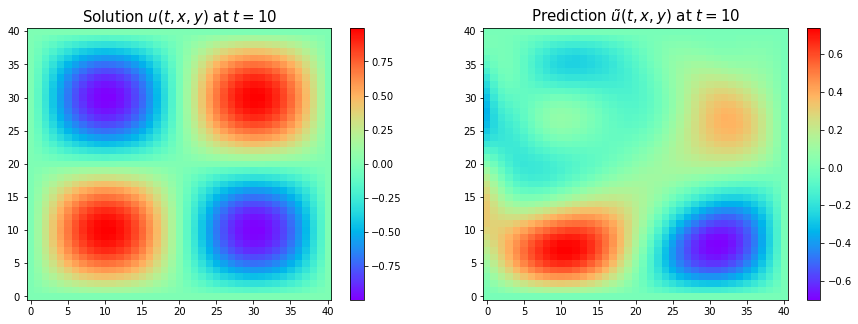

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
h = ax1.imshow(usol[10, :, :], interpolation='nearest', cmap='rainbow', 
              origin='lower', aspect='auto')
ax1.set_title('Solution $u(t, x, y)$ at $t = 10$', fontsize=15)
cbar = f.colorbar(h)

h = ax2.imshow(u_pred[10, :, :], interpolation='nearest', cmap='rainbow', 
              origin='lower', aspect='auto')

cbar = f.colorbar(h)

ax2.set_title('Prediction $\\tilde{u}(t, x, y)$ at $t = 10$', fontsize=15)

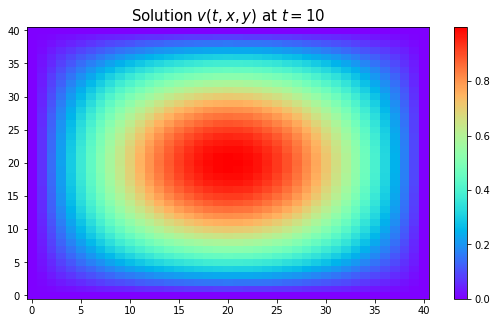

In [44]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(vsol[10, :, :], interpolation='nearest', cmap='rainbow', 
              origin='lower', aspect='auto')

ax.set_title('Solution $v(t, x, y)$ at $t = 10$', fontsize=15)

cbar = fig.colorbar(h)

plt.show()

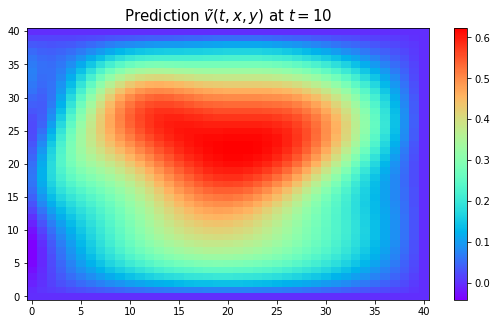

In [47]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(v_pred[10, :, :], interpolation='nearest', cmap='rainbow', 
              origin='lower', aspect='auto')

cbar = fig.colorbar(h)

ax.set_title('Prediction $\\tilde{v}(t, x, y)$ at $t = 10$', fontsize=15)

plt.show()

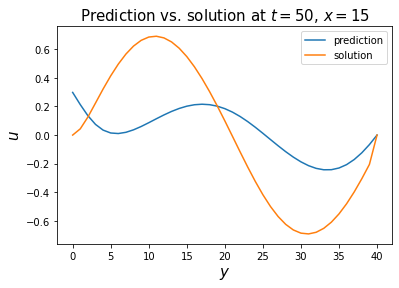

In [42]:
plt.plot(u_pred[50, 15, :], label='prediction')
plt.plot(usol[50, 15, :], label='solution')

plt.title('Prediction vs. solution at $t=50$, $x=15$', fontsize=15)
plt.xlabel('$y$', fontsize=15)
plt.ylabel('$u$', fontsize=15)

plt.legend()
plt.show()